In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7ee60008ce4027a447136eca5cac66b07b682ddd90aa2c733ca72618d1b9fe78
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from google.colab import drive
from pyspark.sql.functions import max as spark_max

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
link = '/content/drive/My Drive/LSH REC'

In [ ]:
sc = SparkSession.builder.appName("Product_Recommendation") \
.config ("spark.sql.shuffle.partitions", "16") \
.config("spark.driver.maxResultSize","4g") \
.config ("spark.sql.execution.arrow.enabled", "true") \
.config("spark.driver.memory", "4g") \
.config("spark.executor.cores", "4") \
.getOrCreate()

sc.sparkContext.setLogLevel("ERROR")

In [ ]:
df = sc.read.option('header', True).csv(link)


In [ ]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
df.show(5, truncate=False)

+-----------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|event_time             |event_type|product_id|category_id        |category_code            |brand |price |user_id  |user_session                        |
+-----------------------+----------+----------+-------------------+-------------------------+------+------+---------+------------------------------------+
|2019-11-01 00:00:00 UTC|view      |1003461   |2053013555631882655|electronics.smartphone   |xiaomi|489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|
|2019-11-01 00:00:00 UTC|view      |5000088   |2053013566100866035|appliances.sewing_machine|janome|293.65|530496790|8e5f4f83-366c-4f70-860e-ca7417414283|
|2019-11-01 00:00:01 UTC|view      |17302664  |2053013553853497655|NULL                     |creed |28.31 |561587266|755422e7-9040-477b-9bd2-6a6e8fd97387|
|2019-11-01 00:00:01 UTC|view      |3601530   |2053013563810775923|app

EDA

In [ ]:
# Null values

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|      1340|      1340|      1340|       1340|       332997|155289| 1340|   1340|        1340|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+



<Axes: ylabel='count'>

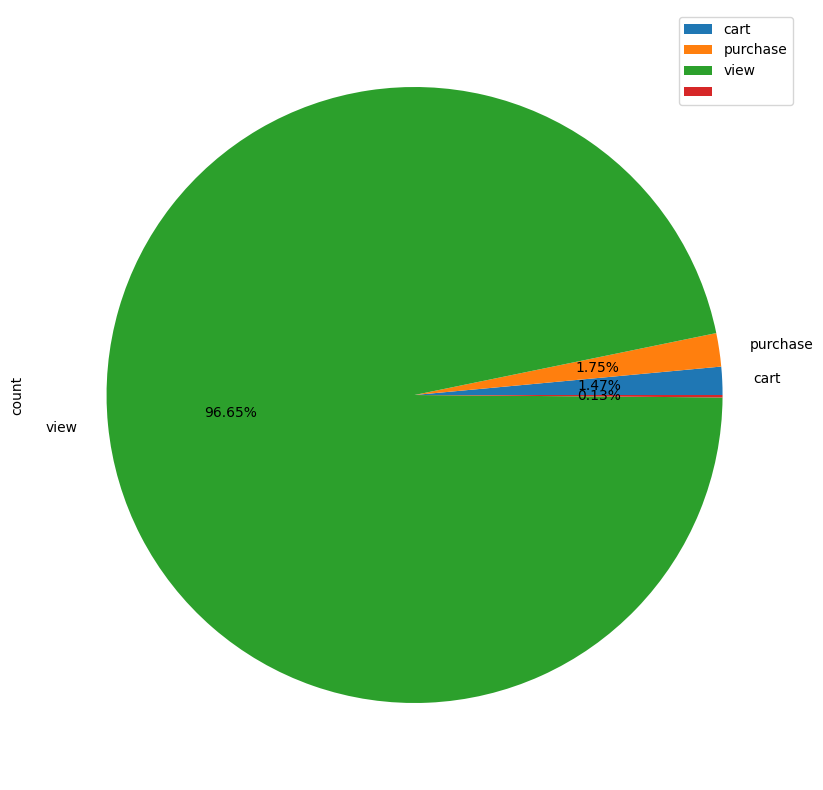

In [ ]:
# Plot events distribution

events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(10, 10))

In [ ]:
df.select(f.countDistinct("product_id")).show()

# 67k products

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                     67330|
+--------------------------+



In [ ]:
df.groupby('product_id').agg(f.collect_set('category_id'))\
                        .filter(size(col('collect_set(category_id)')) == 1).count()

# All products belong to a single category

67330

In [ ]:
df.select(f.countDistinct("category_id")).show()

# 605 categories

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        605|
+---------------------------+



In [ ]:
df.drop_duplicates(subset=['category_id']).select(f.count("category_code")).show()

# Some categories (238/684) have a category code represantation

+--------------------+
|count(category_code)|
+--------------------+
|                 238|
+--------------------+



In [ ]:
df.select(f.countDistinct("category_code")).show()

# 123 distinct category code represantations,

+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          123|
+-----------------------------+



In [ ]:
df.select(f.countDistinct("user_id")).show()

# .17m users in one month

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 176569|
+-----------------------+



In [ ]:
df.select(f.countDistinct("user_session")).show()

# .24m sessions

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                      247170|
+----------------------------+



<Axes: xlabel='date'>

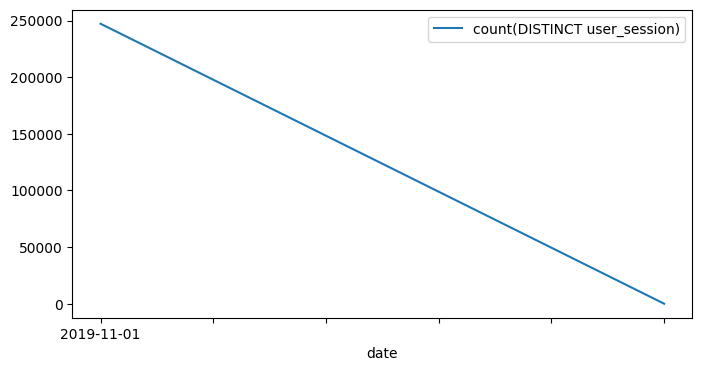

In [ ]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

In [ ]:
# Print the number of interactions between users and products, sorted by carts

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1)).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1)).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))

interactions.sort('carts', ascending=False).show()

+---------+----------+-----+-----+---------+
|  user_id|product_id|views|carts|purchases|
+---------+----------+-----+-----+---------+
|521350556|   1005217|   18|   62|        1|
|520670468|   3600231|    2|   46|     NULL|
|518324787|   3700912|   12|   45|        1|
|558728074|   3600231|    3|   32|        2|
|551988491|   1004767|    4|   32|     NULL|
|564133858|   1004856|    8|   27|        6|
|536869352|   5000184|   13|   23|        1|
|566321339|   1004785|    2|   22|        1|
|519125687|   2601106|    6|   20|        1|
|515934670|   1005129|   28|   19|       14|
|557947356|   1005100|   10|   19|        4|
|527762642|   1801766|    6|   19|     NULL|
|561853053|   1004565|    2|   19|     NULL|
|513005536|   1004834|    2|   18|        1|
|521575529|   4803976|    2|   16|        1|
|558728074|   1004767|    2|   16|        1|
|512481982|   1004856|    4|   15|        1|
|548795524|   1005100|    8|   15|     NULL|
|566378268|   8500297|   11|   15|     NULL|
|543689735

Data Preprocessing

In [ ]:
def preprocess(df):

    # Change data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('category_id', col('category_id').cast('long'))

    # Limit the number of carts to 1 per session for each user-product pair
    cart_df = df.filter(col('event_type') == 'cart')
    df = df.filter(col('event_type') != 'cart')
    cart_df = cart_df.dropDuplicates(subset=['product_id', 'user_id', 'user_session'])
    df = df.union(cart_df)

    # Split category codes into sub categories
    #df = df.withColumn('category', split(df['category_code'], '\.').getItem(0)) \
    #   .withColumn('sub_category', split(df['category_code'], '\.').getItem(1)) \
    #   .withColumn('sub_sub_category', split(df['category_code'], '\.').getItem(2))

    return df

In [ ]:
df = preprocess(df)

In [ ]:
df.head()

Row(event_time=datetime.datetime(2019, 11, 1, 0, 0), event_type='view', product_id=1003461, category_id=2053013555631882655, category_code='electronics.smartphone', brand='xiaomi', price='489.07', user_id=520088904, user_session='4d3b30da-a5e4-49df-b1a8-ba5943f1dd33', date='2019-11-01')

 Feature Engineering

We can extract several features for users, products and categories using the behavioral data:

Views/carts/purchases: The number of times a user has interacted with a product.
Distinct products viewed/carted/purchased: The number of unique products a user has viewed, added to their cart, or purchased.
Average (relative) price viewed/purchased: The average price of products a user has viewed or purchased.
Interaction rates: These are derived features that provide insights into the behavior of users, such as the purchase per view, cart per view, and purchase per cart rate.


In [ ]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'view', True)).alias('views'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

In [ ]:
def category_features(df):

    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'view', True)).alias('views'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    df = df.join(products, on='category_id')

    return df

In [ ]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'view', True)).alias('views'),
                                   count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'view', col('product_id'))).alias('distinct_products_viewed'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'view', col('price'))).alias('average_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'view', col('relative_price'))).alias('avg_relative_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', when(df['views'] == 0, df['purchases']).otherwise(df['purchases'] / df['views']))
    df = df.withColumn('cart_per_view', when(df['views'] == 0, df['carts']).otherwise(df['carts'] / df['views']))
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

Some products and categories have very few interactions, this makes their interaction rates unreliable. For example, a product that has been viewed only 2 times and purchased 1 time would have a purchase per view rate of 0.5, which is very high. Therefore, it's important to apply smoothing to avoid overfitting on small sample sizes.

The smoothing works by taking a weighted average of the product's rate and the category's rate. The weight given to the product's rate depends on the number of interactions, with more weight given to the product's rate as the number of interactions increases. The same smoothing is applied to categories as well, using the overall average interaction rates.

In [ ]:
# Calculate smoothed rates for categories with small sample size using means of all products to combat overfitting

def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):

    # Weighted average of category value and overall mean
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))

    return categories

In [ ]:
# Calculate smoothed rates for products with small sample size using category means to combat overfitting

def product_smoothener(products, categories, attr, rate, min_sample_size=1000):

    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')

    # Weighted average of product value and category value
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))

    products = products.drop(category_rate)
    return products

We must calculate the relative price of each product with respect to its category by scaling its price based on the median and Inter Quartile Range of the category's prices. The median is used as a measure of central tendency and the IQR as a measure of variability.

This scaling accounts for differences in price ranges across categories, enabling us to compare product prices across categories more accurately and without bias. Relative prices will be used to determine if users have a tendency to interact with cheaper or more expensive products.

In [ ]:
# Calculate the price of each product relative to its category using the formula: (price - median) / IQR

def calculate_relative_price(products):

    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))

    # Calculate relative price
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))

    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [ ]:
# Extract product and category features

products = product_features(df)
categories = category_features(df)

In [ ]:
# Calculate relative prices and append it to the main dataframe and product features

relative_prices = calculate_relative_price(products)

df = df.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')

In [ ]:
# Calculate the average interaction rates for all products to smooth category features with low interaction

avg_purchase_per_view = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_cart_per_view = events[events['event_type'] == 'cart']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_view, 'views', 'purchase_per_view', 2000)
categories = category_smoothener(categories, avg_cart_per_view, 'views', 'cart_per_view', 2000)
categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [ ]:
# Smooth product features with low interaction using corresponding category features

products = product_smoothener(products, categories, 'views', 'purchase_per_view', 1000)
products = product_smoothener(products, categories, 'views', 'cart_per_view', 1000)
products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [ ]:
# Extract user features

users = user_features(df)


In [ ]:
# Top 50 products in terms of purchases

products.sort('purchases', ascending=False).toPandas().head(50)

,category_id,product_id,category_code,views,carts,purchases,price,first_date,last_date,purchase_per_view,cart_per_view,purchase_per_cart,relative_price
0,2053013555631882655,1004856,electronics.smartphone,10690,529,808,128.313639,2019-11-01 00:00:23,2019-11-01 16:00:51,0.075585,0.049486,1.527410,-0.241126
1,2053013555631882655,1004767,electronics.smartphone,9400,455,512,242.371217,2019-11-01 00:00:30,2019-11-01 16:00:47,0.054468,0.048404,1.125275,0.039902
2,2053013555631882655,1005115,electronics.smartphone,9576,405,446,946.342342,2019-11-01 00:00:10,2019-11-01 16:00:45,0.046575,0.042293,1.101235,1.774422
3,2053013555631882655,1004833,electronics.smartphone,5233,316,389,171.875812,2019-11-01 00:00:49,2019-11-01 16:00:51,0.074336,0.060386,1.231013,-0.133792
4,2053013555631882655,1002544,electronics.smartphone,4760,244,309,458.265878,2019-11-01 00:00:14,2019-11-01 16:00:48,0.064916,0.051261,1.266393,0.571847
5,2053013554658804075,4804056,electronics.audio.headphone,4797,268,300,160.279059,2019-11-01 00:01:30,2019-11-01 16:00:46,0.062539,0.055868,1.119403,1.650693
6,2053013555631882655,1004870,electronics.smartphone,5111,265,242,273.122793,2019-11-01 00:01:33,2019-11-01 16:00:49,0.047349,0.051849,0.913208,0.115671
7,2053013555631882655,1004249,electronics.smartphone,5471,217,231,722.713992,2019-11-01 00:02:38,2019-11-01 16:00:45,0.042223,0.039664,1.064516,1.223423
8,2053013555631882655,1005105,electronics.smartphone,5296,204,216,1348.540675,2019-11-01 00:03:27,2019-11-01 16:00:44,0.040785,0.038520,1.058824,2.765402
9,2053013555631882655,1004836,electronics.smartphone,3462,199,201,229.900000,2019-11-01 00:02:11,2019-11-01 16:00:41,0.058059,0.057481,1.010050,0.009174


Collaborative Filtering

Collaborative filtering is a technique used in recommendation systems to provide personalized recommendations to users based on their past interactions with items as well as the interactions of similar users. The interaction matrix contains information about which users have interacted with which items, and to what degree.

Alternating Least Squares algorithm is one approach to collaborative filtering that can be used to train a model on this interaction matrix. The model learns latent factors for both users and items, which can then be used to make personalized recommendations and to find similar products.

We should apply a weighting function to interactions based on recency. This is because recent interactions are often more indicative of a user's current preferences than older interactions. We can use a half-life decay function, where the weight given to an interaction decreases by half after a certain time interval (20 days). By weighting more recent interactions more heavily, the algorithm can provide more relevant recommendations to users.

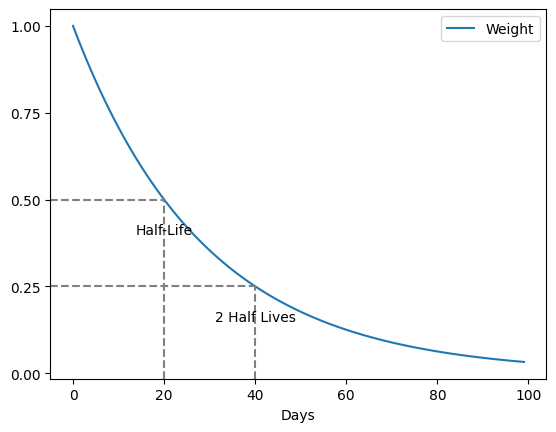

In [ ]:
# Plot the half-life decay function

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df_ = pd.DataFrame({'Days': x, 'Weight': y})

# Plot the function
ax = df_.plot(x='Days', y='Weight')

# Add vertical lines at 20 and 40 days with explanatory text
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)
ax.text(20, 0.4, 'Half-Life', ha='center')
ax.text(40, 0.15, '2 Half Lives', ha='center')

plt.show()

In [ ]:
''''# Get the timestamp of the most recent event in the df
last_date = df['event_time'].max()
df = df.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df = df.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df = df.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df = df.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

'''

last_date = df.agg(spark_max('event_time')).collect()[0][0]
df = df.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df = df.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df = df.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df = df.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

In [ ]:
df.columns

['product_id',
 'event_time',
 'event_type',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'date',
 'relative_price',
 'recency',
 'recency_coef']

In [ ]:
# Find the number of views, carts and purchases for each user-product pair
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

The interaction matrix is calculated by assigning weights to each type of user interaction. These weighted interactions are then summed to get the total interaction score, which has been subject to a half-life decay function to give more weight to recent interactions. Finally, the values are transformed by taking the logarithm with base 10 and capping the maximum value at 100 to ensure scalability and consistency, while reducing the effect of outliers. The resulting matrix provides a measure of strength of the relationship between users and products.

In [ ]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):

    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))

    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))

    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [ ]:
interaction_matrix = calculate_interaction_matrix(interactions)

In [ ]:
#  User-product pairs with the highest interaction scores

interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+------------------+
|  user_id|product_id|             views|             carts|         purchases|       interaction|
+---------+----------+------------------+------------------+------------------+------------------+
|526933626|   1004833|23.695591265009575| 3.959487226853955|16.779119383934553|1.3291236823861703|
|515934670|   1005129|27.616821866707753|11.836816926932512|13.812627750654682|1.3248040160802361|
|514544847|  12700930|30.565111460181225|1.9698372474979715|13.808893638583443|1.2661459576223772|
|544048413|  27400000|30.657308134951457|               0.0|13.849220036762864|1.2532156210150507|
|515676312|   1002544|27.925605329911377|1.9930265798788631|12.963852430003868| 1.239407624685534|
|551801600|   1003306| 22.79145126056842| 3.956883506041459|11.903182904505917| 1.214032577648858|
|529831093|   6000227| 19.68012316348172| 6.890376385999631| 9.840950954934293|1.1724883939101622|
|562363949

In [ ]:
interaction_matrix.count()

636683

In [ ]:
sampled_df = interaction_matrix.limit(20000)


In [ ]:
sampled_df.show()

+---------+----------+------------------+-----+---------+--------------------+
|  user_id|product_id|             views|carts|purchases|         interaction|
+---------+----------+------------------+-----+---------+--------------------+
|532364121|  12708937|1.9543019066721017|  0.0|      0.0| 0.07752421977155047|
|512416379|  34600011|0.9771411542910079|  0.0|      0.0| 0.04048924880456979|
|513200477|   3901174| 2.937627305071467|  0.0|      0.0| 0.11185463624006871|
|521368162|  10301494|0.9771489934733337|  0.0|      0.0|0.040489558950204535|
|513726400|  12708937| 0.977150169356107|  0.0|      0.0|0.040489605472245255|
|517081324|  12301394|0.9771572246824617|  0.0|      0.0| 0.04048988460556053|
|548645138|  22700202|0.9771587925396807|  0.0|      0.0|  0.0404899466354355|
|551943550|   5800506|0.9771591845043787|  0.0|      0.0| 0.04048996214291844|
|515849878|  17601982|0.9771631041600044|  0.0|      0.0| 0.04049011721805911|
|561587266|  17301421|0.9771638880930164|  0.0|     

After creating an interaction matrix that quantifies user-product interactions using weights, we can feed this matrix into the ALS algorithm. This algorithm uses the matrix to learn the latent factors of both users and products, which can then be used to make personalized recommendations for users.

To optimize the performance of the ALS algorithm, we can use a cross-validation pipeline, which allows us to test and fine-tune different sets of parameters to find the best configuration for our recommendation system. Ultimately, the goal is to create a model that can make accurate and relevant product recommendations to users based on their previous interactions with the system.

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [ ]:
def cross_validate_als(sampled_df):

    # Define the ALS model
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=True)

    # Define the parameter grid for hyperparameter tuning
    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [5, 10, 15, 20]) \
        .addGrid(als.regParam, [0.005, 0.01, 0.05, 0.1]) \
        .addGrid(als.alpha, [0, 1.0, 5.0]) \
        .build()

    # Define the evaluator for computing the evaluation metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')

    # Define the cross-validator for performing 5-fold cross-validation
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)

    # Define the pipeline for fitting the model and evaluating it
    pipeline = Pipeline(stages=[cv])

    # Fit the pipeline on the data and evaluate the model
    model = pipeline.fit(sampled_df)

    return model

In [ ]:
model = cross_validate_als(sampled_df)



In [ ]:
# Model with the lowest RMSE value
bestModel = model.stages[0].bestModel

# Make predictions
predictions = bestModel.transform(interaction_matrix)

# Calculate RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))

# Print the parameters of the model with the lowest RMSE value
regParam = bestModel._java_obj.parent().getRegParam()
rank = bestModel._java_obj.parent().getRank()
alpha = bestModel._java_obj.parent().getAlpha()
print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

 rmse:0.30152985063642984 mae:0.1627207435838928
rank:10 regParam:0.1 alpha:0.0


In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(sampled_df):

    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])

    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              alpha=1, regParam=0.005, rank=15, implicitPrefs=True,
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)

    # Make predictions
    predictions = model.transform(test)

    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))

    return model

In [ ]:
als_model = simple_als(sampled_df)

test rmse:0.0937713441849025 mae:0.06727751022956223


In [ ]:
sampled_df.show(1000)

+---------+----------+------------------+------------------+------------------+--------------------+
|  user_id|product_id|             views|             carts|         purchases|         interaction|
+---------+----------+------------------+------------------+------------------+--------------------+
|532364121|  12708937|1.9543019066721017|               0.0|               0.0| 0.07752421977155047|
|512416379|  34600011|0.9771411542910079|               0.0|               0.0| 0.04048924880456979|
|513200477|   3901174| 2.937627305071467|               0.0|               0.0| 0.11185463624006871|
|521368162|  10301494|0.9771489934733337|               0.0|               0.0|0.040489558950204535|
|513726400|  12708937| 0.977150169356107|               0.0|               0.0|0.040489605472245255|
|517081324|  12301394|0.9771572246824617|               0.0|               0.0| 0.04048988460556053|
|548645138|  22700202|0.9771587925396807|               0.0|               0.0|  0.04048994

In [ ]:
#516200807, 532107139, 523966975

In [ ]:
# 3 random users
user_subset = [516200807, 532107139, 523966975]

# Recommend top 500 products for the users
recommendations = sc.createDataFrame([(user, 0) for user in user_subset], ['user_id', 'product_id'])
recommendations = als_model.recommendForUserSubset(recommendations, 500)

In [ ]:
recommendations.show()

+---------+--------------------+
|  user_id|     recommendations|
+---------+--------------------+
|532107139|[{26405179, 0.0},...|
|516200807|[{1005160, 0.0459...|
|523966975|[{1005116, 0.3932...|
+---------+--------------------+

